In [1]:
#!rm -r AI2022MA/
#!git clone https://github.com/UmbertoJr/AI2022MA.git

# The Orienteering Problem with Time Windows

column of X:

0. index of the customer
1. x coordinate
2. y coordinate
3. lower time window
4. uppper time window
5. reward customer
6. global time constraint

adj is the distance matrix

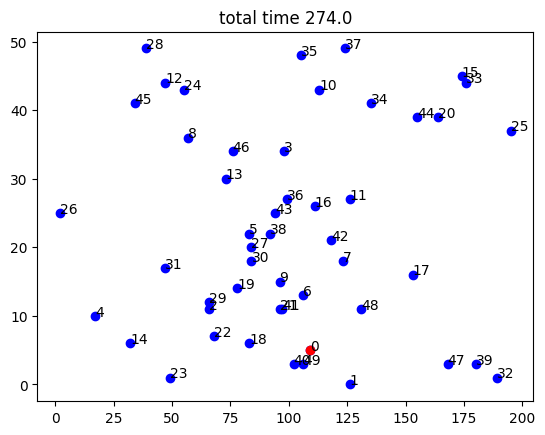

[[0.00e+00 1.09e+02 5.00e+00 0.00e+00 2.74e+02 0.00e+00 2.74e+02]
 [1.00e+00 1.26e+02 0.00e+00 2.13e+02 2.32e+02 1.70e-01 2.74e+02]
 [2.00e+00 6.60e+01 1.10e+01 2.31e+02 2.31e+02 4.00e-01 2.74e+02]
 [3.00e+00 9.80e+01 3.40e+01 1.31e+02 1.69e+02 2.90e-01 2.74e+02]
 [4.00e+00 1.70e+01 1.00e+01 1.82e+02 1.82e+02 8.40e-01 2.74e+02]]
(50, 7)
(50, 50)


In [2]:
import numpy as np
from AI2022MA.OPTW import Env, plot_instance

env = Env(from_file=True, instance_number=0)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

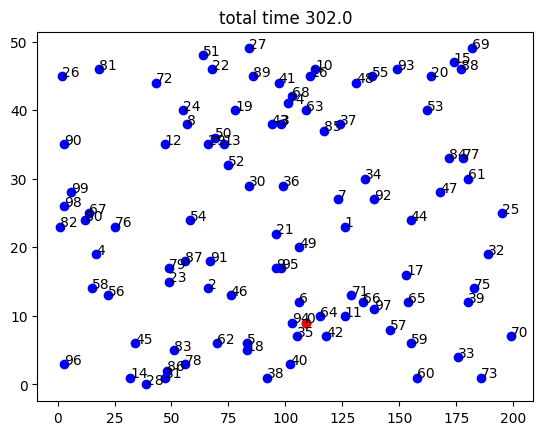

[[0.00e+00 1.09e+02 9.00e+00 0.00e+00 3.02e+02 0.00e+00 3.02e+02]
 [1.00e+00 1.26e+02 2.30e+01 2.06e+02 2.25e+02 2.00e-01 3.02e+02]
 [2.00e+00 6.60e+01 1.40e+01 4.00e+01 7.10e+01 3.80e-01 3.02e+02]
 [3.00e+00 9.80e+01 3.80e+01 1.17e+02 1.49e+02 2.80e-01 3.02e+02]
 [4.00e+00 1.70e+01 1.90e+01 2.09e+02 2.09e+02 8.20e-01 3.02e+02]]
(100, 7)
(100, 100)


In [3]:
env = Env(from_file=True, instance_number=1)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

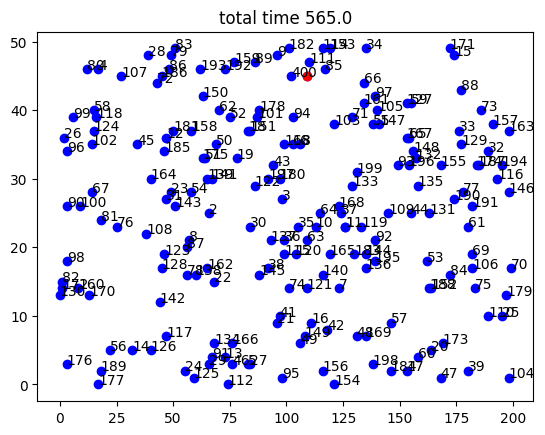

[[0.00e+00 1.09e+02 4.50e+01 0.00e+00 5.65e+02 0.00e+00 5.65e+02]
 [1.00e+00 1.26e+02 2.30e+01 1.41e+02 1.78e+02 2.50e-01 5.65e+02]
 [2.00e+00 6.60e+01 2.50e+01 5.18e+02 5.18e+02 4.10e-01 5.65e+02]
 [3.00e+00 9.80e+01 2.70e+01 2.40e+01 7.10e+01 1.90e-01 5.65e+02]
 [4.00e+00 1.70e+01 4.60e+01 4.73e+02 4.73e+02 8.00e-01 5.65e+02]]
(200, 7)
(200, 200)


In [4]:
env = Env(from_file=True, instance_number=2)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

### check if solution is feasible and print it

time window violated 225.0 
current time  233.0 
from node 1  to  49
(233.0, 0, False)


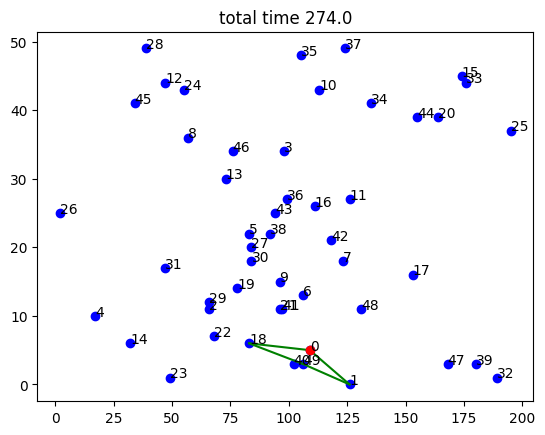

In [5]:
sol = [0, 1, 49, 18, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

(236.0, 0.44999999999999996, True)


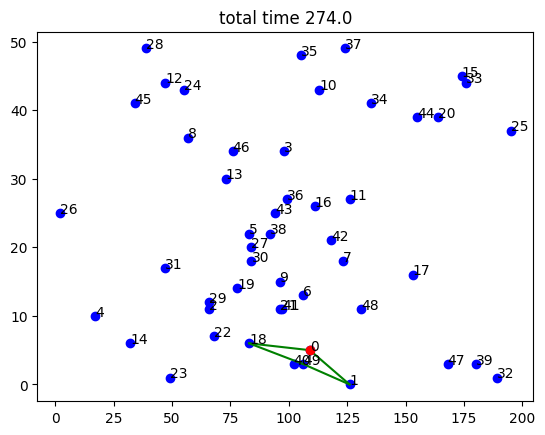

In [6]:
sol = [0, 18, 49, 1, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

# Monte Carlo Tree Search

### Node class for the Tree Search


In [7]:
### Node Object ###
class Node:
    def __init__(self, parent, node, travel_time, partial_path, current_reward, expandable_customers):
      self.parent = parent                                                      # parent node object 
      self.node = node                                                          # current node (or customer) index
      self.partial_path = partial_path                                          # current partial path across customers
      self.current_reward = current_reward                                      # current reward collected in the partial path
      self.num_of_visit = 0                                                     # number of visit to the current node during the MCTS 
      self.terminal = False                                                     # boolean to determine if node is terminal
      self.fully_expanded = False                                               # boolean to determine if node was expanded completely during the search
      self.estimated_reward = 0                                                 # esteem of the future reward collected thanks to the MC simulations
      self.travel_time = travel_time                                            # travel time spent with the current partial path
      self.score = None                                                         # Upper Confidence Buond score for node
      self.policy = None                                                        # IMPORTANT !!!!! Best node index according to the UCB score 
      self.expandables = copy.deepcopy(expandable_customers)                    # customers in the candidate list of the current node that are not in the current path
      self.expanded = {}
      self.reward = 0# nodes already expanded during the search
      
      if len(self.expandables) == 0:                                            
        self.fully_expanded = True
        self.terminal = True
        self.partial_path.append(0)
        self.policy = 0

    def calculateUCTscore(self, best_reward_so_far):
      # computes the Upper Confidence Bound for the Node
      c = 1 / (2 ** 0.5)
      self.score = (((self.estimated_reward/ self.num_of_visit) + self.current_reward) /
                    best_reward_so_far) + c * 2 * (2 * np.log(self.parent.num_of_visit) / 
                                                   self.num_of_visit) ** 0.5


### MCTS

In [8]:
from time import time
import copy
import numpy as np
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import math

class MCTS:
  def __init__(self, env,time_limit, initial_path):
    self.num_of_customers = env.n_nodes                                         # number of customers in the current problem
    self.env = env                                                              # environment of the problem to solve
    self.time_limit = time_limit                                                # time budget for the OPTW to solve
    self.initial_path = initial_path                                            # initial path
    self.root_node = initial_path[-1]                                           # root node index

    # saving the best tour so far, its reward and time travel
    self.best_tour_so_far = initial_path + [0]
    self.travel_time, self.max_reward, _ = self.env.check_solution(self.best_tour_so_far)

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5] / (self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in initial_path 
                    and self.env.adj[self.root_node, i] + self.travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[self.root_node, i] + self.travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in initial_path]

    # initialize the root node
    self.root = Node(parent=None,
                     node= self.root_node,
                     travel_time =self.travel_time,
                     partial_path=initial_path,
                     current_reward=0, 
                     expandable_customers=ordered_list)


  def treePolicy(self, node):
    """
    This function expand a node if the selected node is not being completely expanded,
    otherwise it select the best child in the Tree using the selectBestChild function
    """
    # TO DO
    # implement the tree policy
    while not node.terminal:
        if not node.fully_expanded:
            return self.expand(node)
        else:
            node = self.selectBestChild(node)
    return node
    

  def selectBestChild(self, node):
    """
    The function updates the UBC score for each child node by employing the updated max_reward
    then it returns the best child according to such score. 
    """
    best_score = 0
    best_child = None
    for index, child in node.expanded.items():
        child.calculateUCTscore(self.max_reward)
        if child.score > best_score:
            best_score = child.score
            best_child = child
            node.policy = index
    return best_child
    


  def expand(self, node):
    new_node = node.expandables.pop()                                           # it selects the most promising node from the CL 
    new_path = copy.deepcopy(node.partial_path)                                 # it copies the path and append new node to it
    new_path.append(new_node)
        
    new_reward = node.current_reward                                            # update of the reward for the new customer
    new_reward += self.env.x[new_node, 5]

    new_travel_time = max(node.travel_time + self.env.adj[node.node, new_node], # updated the travel time
                          self.env.x[new_node, 3])

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in new_path 
                    and self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in new_path]

    new_node_object = Node(parent=node,
                           node=new_node,
                           travel_time=new_travel_time,
                           partial_path=new_path,
                           current_reward=new_reward, 
                           expandable_customers=ordered_list)
    
    node.expanded[new_node] = new_node_object
    if len(node.expandables) == 0:
      node.fully_expanded = True
      
    if new_node == 0:
      new_node_object.terminal = True
      _, new_r, _ = self.env.check_solution(new_path)
      if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_node_object

  def defaultPolicy(self, starting_node):
    # reach the end, break condition
    if starting_node.node == 0:
      return 0

    customer = starting_node.node
    new_path = starting_node.partial_path
    travel_time = starting_node.travel_time
    while customer != 0:
      # these operations find the promising CL for the root node
      ordered_view = {i: (self.env.x[i, 5] + np.finfo(float).eps)/(self.env.x[i, 3] / self.env.x[i, 6] + np.finfo(float).eps ) for i in range(1, self.num_of_customers) if i not in new_path 
                      and self.env.adj[customer, i] + travel_time < self.env.x[i, 4] 
                      and self.env.adj[i, 0] + self.env.adj[customer, i] + travel_time < self.env.x[i, 6]}
      self.ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]
      if not self.ordered_list:
        customer = 0
      else:
        probabilities = softmax(np.array([v for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]))
        customer = int(np.random.choice(self.ordered_list, 1, p=probabilities))

      new_path.append(customer)
      travel_time = max(travel_time + self.env.adj[new_path[-2], customer], self.env.x[customer, 3])

    _, new_r, _ = self.env.check_solution(new_path)
    if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_r - starting_node.current_reward
      

  def backup(self, node, reward_esteem):
    """
    backup of the estimated reward in the MCTS
    """
    # TO DO
    while node is not None:
        node.num_of_visit += 1
        node.reward += reward_esteem
        node = node.parent

    
  

  def step(self, num_of_simulation=1):
    start = time()
    while time() - start < self.time_limit:
        current_node = self.treePolicy(self.root)
        reward_esteem = self.defaultPolicy(current_node)
        self.backup(current_node, reward_esteem)

    return self.root.policy if self.root.policy != None else 0

using seed 0 --- instance 0
(274.0, 1.0, True)


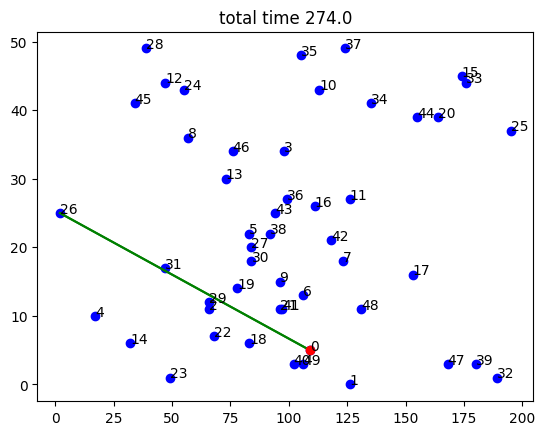

(274.0, 2.22, True)


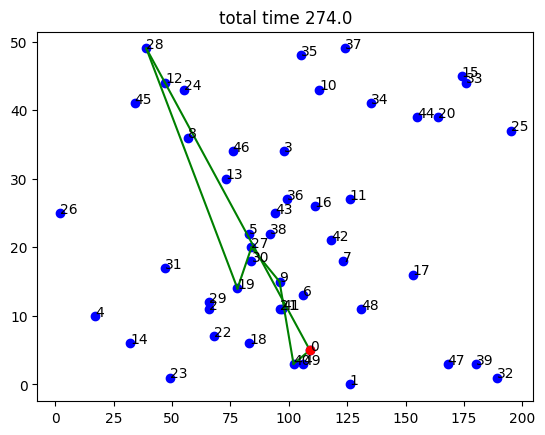

using seed 43 --- instance 0
(274.0, 1.0, True)


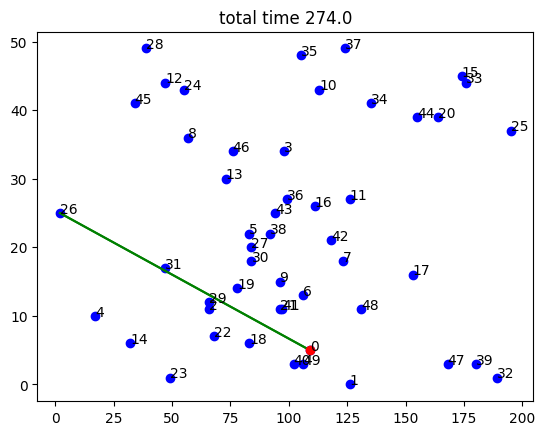

(274.0, 1.87, True)


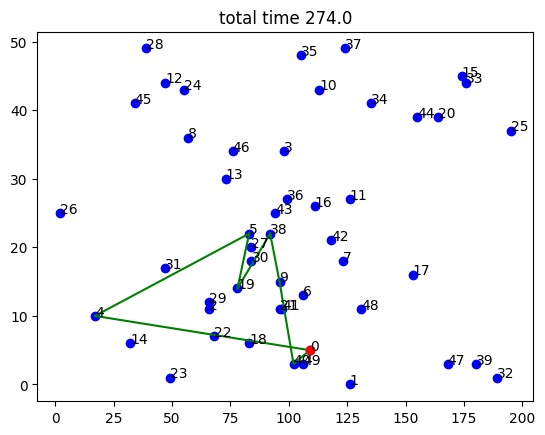

using seed 143 --- instance 0
(274.0, 1.0, True)


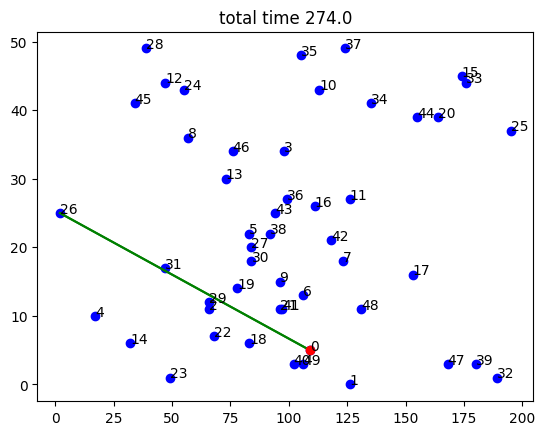

(274.0, 1.44, True)


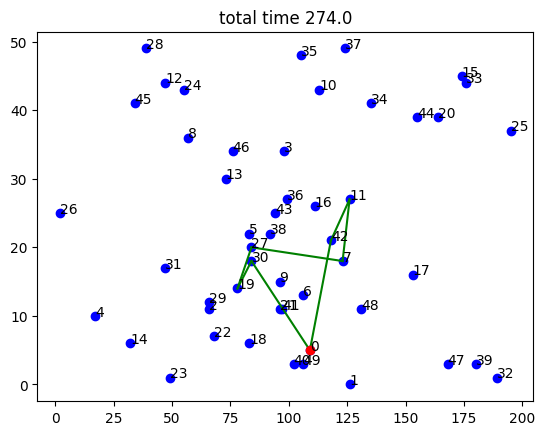

using seed 0 --- instance 1
(302.0, 0.96, True)


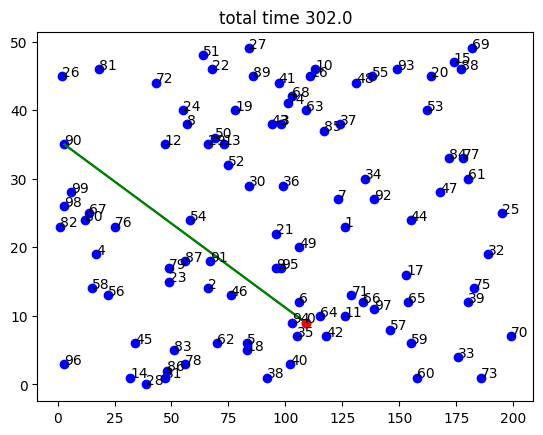

(302.0, 1.35, True)


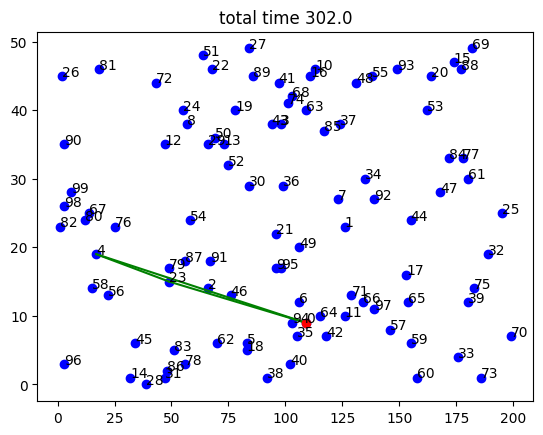

using seed 43 --- instance 1
(302.0, 0.97, True)


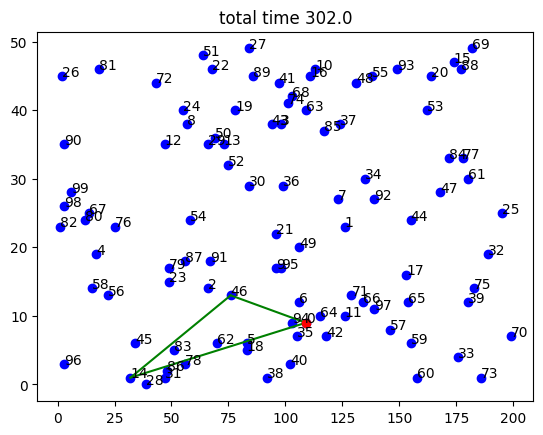

(302.0, 1.7599999999999998, True)


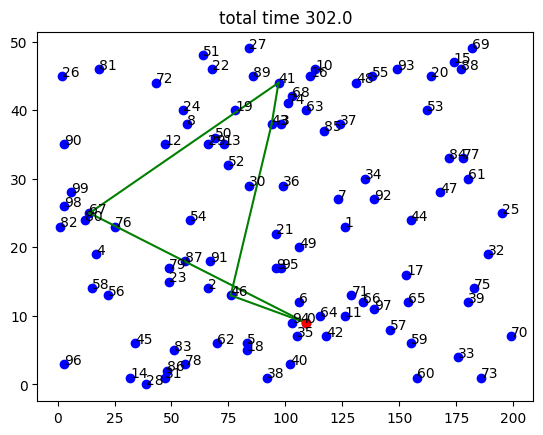

using seed 143 --- instance 1
(302.0, 0.96, True)


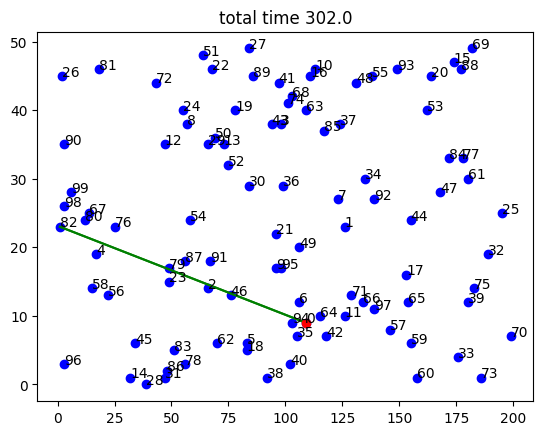

(302.0, 1.3800000000000001, True)


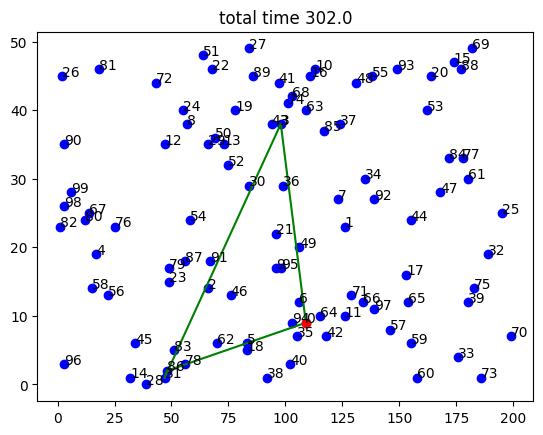

using seed 0 --- instance 2
(565.0, 0.29, True)


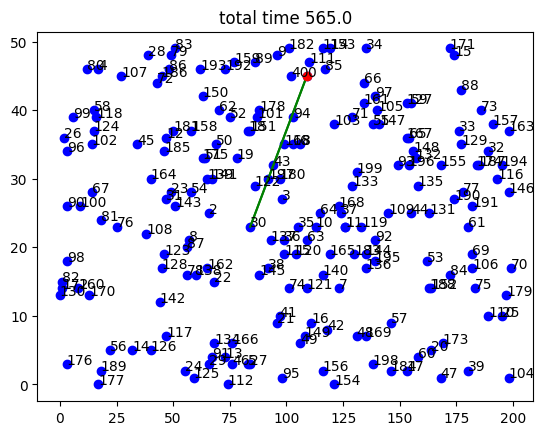

(565.0, 2.16, True)


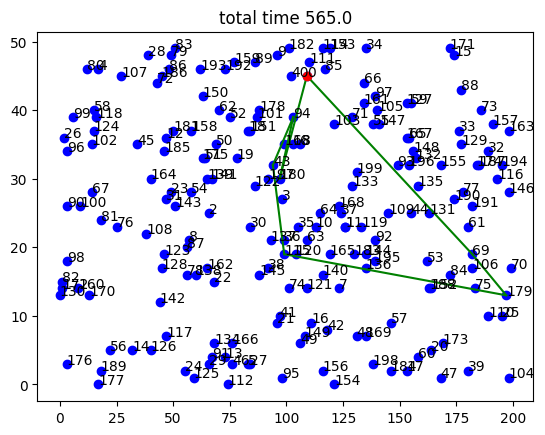

using seed 43 --- instance 2
(565.0, 0.07, True)


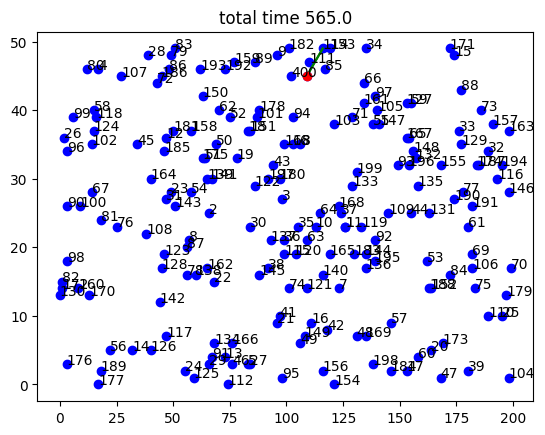

(565.0, 2.58, True)


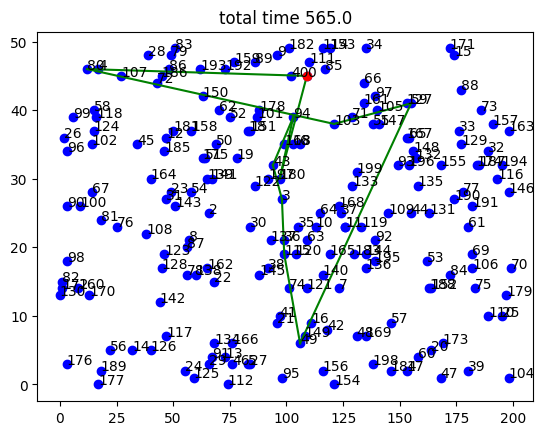

using seed 143 --- instance 2
(565.0, 0.56, True)


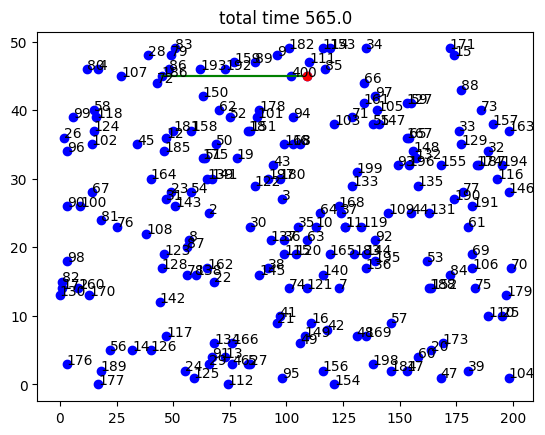

(565.0, 2.58, True)


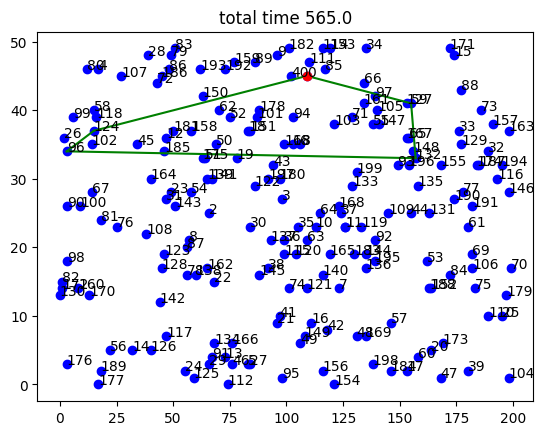

In [9]:
seeds = [0, 43, 143]
instances =[0,1, 2]
import random
import numpy as np
import matplotlib.pyplot as plt
solutions ={"instance": [], "seed":[], "best_sol":[], "tour_time":[], "reward":[]}
time_limit = 5
for instance in instances:
  
  for seed in seeds:
        
    print(f"using seed {seed} --- instance {instance}")
    np.random.seed(seed)
    random.seed(seed)
    env = Env(from_file=True, instance_number=instance)
    sol = [0]
    best_sol = None
    best_r = 0

    while True:
      mcts = MCTS(env, time_limit, sol)
      mcts.best_tour_so_far = best_sol
      mcts.max_reward = best_r
      new_customer = mcts.step()
      # print("a new customer is", new_customer)
      sol.append(new_customer)

      if mcts.max_reward > best_r:
        best_r = mcts.max_reward
        best_sol = mcts.best_tour_so_far

      if sol[-1] == 0:
        break
    plt.title(f"seed {seed} --- instance {instance}")
    if best_sol is None:
      best_sol= sol

    print(env.check_solution(list(sol)))
    plot_instance(env.x, list(sol))
    print(env.check_solution(list(best_sol)))
    plot_instance(env.x, list(best_sol))
    tour_time, tour_reward, fea = env.check_solution(best_sol)
    solutions["instance"].append(instance)
    solutions["seed"].append(seed)
    solutions["best_sol"].append(best_sol)
    solutions["tour_time"].append(tour_time)
    solutions["reward"].append(tour_reward)

# Some Statistics about Results


       instance        seed   tour_time    reward
count  9.000000    9.000000    9.000000  9.000000
mean   1.000000   62.000000  380.333333  1.926667
std    0.866025   63.539358  139.029673  0.486493
min    0.000000    0.000000  274.000000  1.350000
25%    0.000000    0.000000  274.000000  1.440000
50%    1.000000   43.000000  302.000000  1.870000
75%    2.000000  143.000000  565.000000  2.220000
max    2.000000  143.000000  565.000000  2.580000


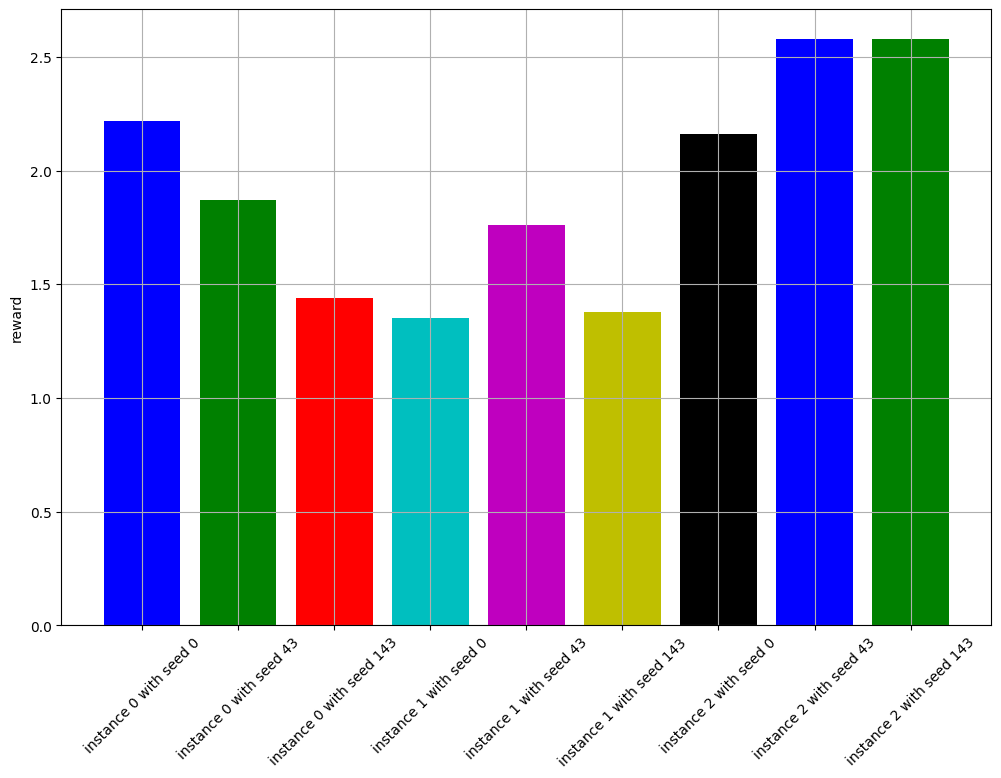

In [10]:
import pandas as pd
data_frame = pd.DataFrame(solutions)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
print(data_frame.describe())
import matplotlib.pyplot as plt
x = [
    f"instance {str(i)} with seed {str(j)}"
    for i, j in zip(solutions["instance"], solutions["seed"])
]
#print(x)
x_num_list = list(range(9))
plt.figure(figsize=(12,8))
plt.bar(x_num_list, solutions["reward"], color=colors)
plt.xticks(x_num_list, x, rotation=45)
#plt.xlabel(x)
plt.grid()
plt.ylabel("reward")
#from scipy.interpolate import UnivariateSpline
#spline = UnivariateSpline(x_num_list, solutions["reward"], k=5)
#x_smooth = np.linspace(x_num_list[0], x_num_list[-1], 1000)
#y_smooth = spline(x_smooth)

# Plot the smooth curve
#plt.plot(x_smooth, y_smooth, 'r-')
# Generate a smooth curve using the spline

#plt.xticks(list(range(len(solutions["instance"]))))
#data_frame.plot(x='instance', y='reward', kind='scatter')	


plt.show()

max time 274.0
max time 302.0
max time 565.0


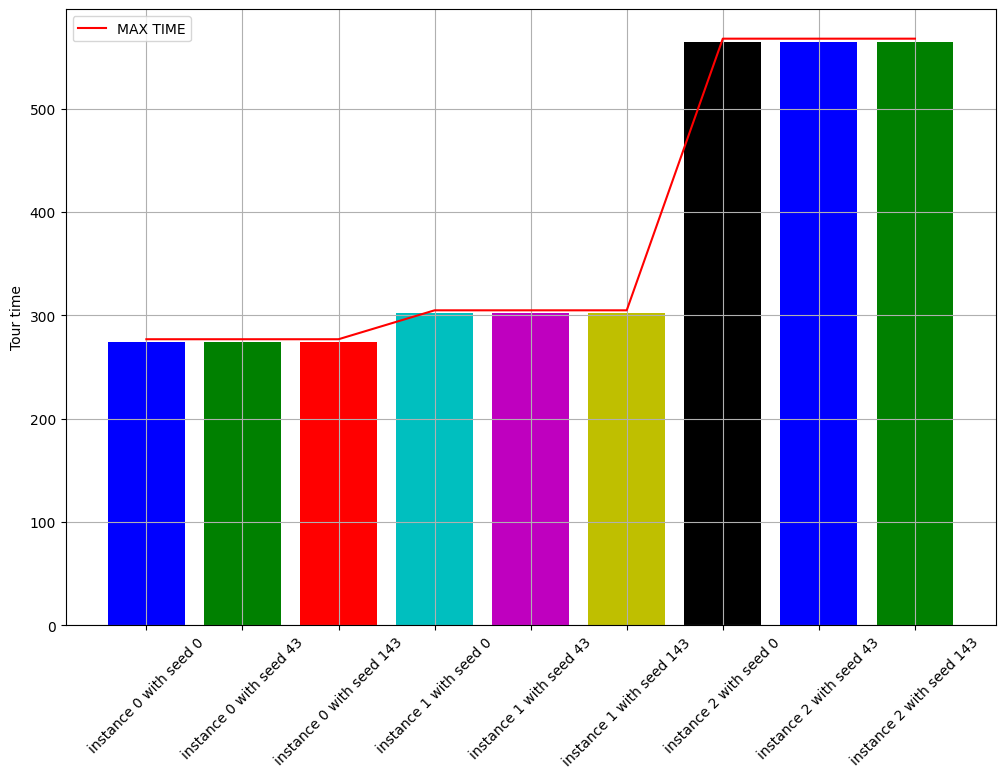

In [11]:
plt.figure(figsize=(12,8))
plt.bar(x, solutions["tour_time"], color=colors)
plt.xticks(list(range(len(solutions["tour_time"]))), x, rotation=45)
#plt.xlabel(x)
plt.grid()
plt.ylabel("Tour time")
path = "AI2022MA/OPTW/instances/instances/instance0000.csv"
time_max_0 = float(pd.read_csv(f"{path}")["MAXTIME"][0])
print("max time", time_max_0)
path = "AI2022MA/OPTW/instances/instances/instance0001.csv"
time_max_1 = float(pd.read_csv(f"{path}")["MAXTIME"][0])
print("max time", time_max_1)
path = "AI2022MA/OPTW/instances/instances/instance0002.csv"
time_max_2 = float(pd.read_csv(f"{path}")["MAXTIME"][0])
print("max time", time_max_2)

# Plot the smooth curve
plt.plot(list(range(9)),([time_max_0+3.]*3) + ([time_max_1+3.]*3) + ([time_max_2+3.]*3), 'r-', label="MAX TIME")
plt.legend()
# Plot the smooth curve
#plt.plot(x_smooth, y_smooth, 'r-')
#plt.plot(x, solutions["tour_time"], 'r-', smooth=True)
#plt.xticks(list(range(len(solutions["instance"]))))
#data_frame.plot(x='instance', y='reward', kind='scatter')	
plt.show()

## Considerations about the results

As expected I got decent results as shown above. I created 2 plots: the first one shows the the $rewards$ according with the instance and the seed, the second one shows the $tour time$ according with the instances and seeds. In fact, since the problem ($instance$) is getting bigger according with the number of nodes, the time spent for the tour is also increasing. 

# Creating my own MCTS

In [12]:
"""env = Env(from_file=True, instance_number=1)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  # print("a new customer is", new_customer)
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break
if best_sol is None:
      best_sol= sol
print(env.check_solution(sol))
plot_instance(env.x, sol)
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)"""

'env = Env(from_file=True, instance_number=1)\ntime_limit = 5\nsol = [0]\nbest_sol = None\nbest_r = 0\nwhile True:\n  mcts = MCTS(env, time_limit, sol)\n  mcts.best_tour_so_far = best_sol\n  mcts.max_reward = best_r\n  new_customer = mcts.step()\n  # print("a new customer is", new_customer)\n  sol.append(new_customer)\n  if mcts.max_reward > best_r:\n    best_r = mcts.max_reward\n    best_sol = mcts.best_tour_so_far\n  if sol[-1] == 0:\n    break\nif best_sol is None:\n      best_sol= sol\nprint(env.check_solution(sol))\nplot_instance(env.x, sol)\nprint(env.check_solution(best_sol))\nplot_instance(env.x, best_sol)'

In [13]:
"""env = Env(from_file=True, instance_number=2)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break
if best_sol is None:
      best_sol= sol
      
print(env.check_solution(list(sol)))
plot_instance(env.x, list(sol))
print(env.check_solution(list(best_sol)))
plot_instance(env.x, list(best_sol))"""

'env = Env(from_file=True, instance_number=2)\ntime_limit = 5\nsol = [0]\nbest_sol = None\nbest_r = 0\nwhile True:\n  mcts = MCTS(env, time_limit, sol)\n  mcts.best_tour_so_far = best_sol\n  mcts.max_reward = best_r\n  new_customer = mcts.step()\n  sol.append(new_customer)\n  if mcts.max_reward > best_r:\n    best_r = mcts.max_reward\n    best_sol = mcts.best_tour_so_far\n  if sol[-1] == 0:\n    break\nif best_sol is None:\n      best_sol= sol\n      \nprint(env.check_solution(list(sol)))\nplot_instance(env.x, list(sol))\nprint(env.check_solution(list(best_sol)))\nplot_instance(env.x, list(best_sol))'

In [14]:
"""import copy
import numpy as np

class myMCTS:
  def __init__(self,env, root, time_limit, reward_limit):
    self.root = root 
    self.env = env# root node object
    self.time_limit = time_limit                    # time limit for MCTS search
    self.reward_limit = reward_limit                # reward limit for MCTS search
    self.best_reward_so_far = float('-inf')         # best reward found so far in the search
    
  def search(self):
    start_time = time.time()                       # start time of MCTS search
    while time.time() - start_time < self.time_limit:  # search until time limit is reached
      # Selection
      node = self.root
      while not node.terminal:
        if not node.fully_expanded:
          break
        node = self.best_child(node, c=1 / (2 ** 0.5))  # choose node with highest UCB score
      
      # Expansion
      if not node.fully_expanded:
        expandable_nodes = node.expandables
        if len(expandable_nodes) > 0:
          new_node = self.expand(node, expandable_nodes)
          node.expanded[new_node.node] = new_node
          if len(expandable_nodes) == 1:
            node.fully_expanded = True
          node = new_node
        else:
          node.fully_expanded = True
          node.terminal = True
      
      # Simulation
      reward = self.simulate(node)
      
      # Backpropagation
      self.backpropagate(node, reward)
      
    # choose best child of root node as the final policy
    self.root.policy = self.best_child(self.root, c=0).node
    return self.root.policy
      
  def best_child(self, node, c):
    
    #Returns the child node with the highest UCB score.
    
    best_score = float('-inf')
    best_child = None
    for child in node.expanded.values():
      score = child.calculateUCTscore(self.best_reward_so_far) + c * np.random.random()
      if score > best_score:
        best_score = score
        best_child = child
    return best_child
  
  def expand(self, node, expandable_nodes):
    
    #Expands the current node by creating a new child node for each expandable node.
    
    return Node(
        parent=node,
        node=expandable_nodes[0],
        travel_time=node.travel_time,
        partial_path=copy.deepcopy(node.partial_path),
        current_reward=node.current_reward,
        expandable_customers=node.expandables,
    )
  
  def simulate(self, node):
          
      #Simulates the reward collected from the current node to the end of the path.
      
          current_node = node
          while not current_node.terminal:
              expandable_nodes = current_node.expandables
              if len(expandable_nodes) > 0:
                  new_node = self.expand(current_node, expandable_nodes)
                  current_node.expanded[new_node.node] = new_node
                  if len(expandable_nodes) == 1:
                      current_node.fully_expanded = True
                      current_node = new_node
              else:
                  current_node.fully_expanded = True
                  current_node.terminal = True
          return current_node.current_reward
      
  def backpropagate(self, node, reward):
      
      #Updates the reward and number of visits for each node in the path from the current node to the root.
      
      current_node = node
      while current_node is not None:
        current_node.num_of_visit += 1
        current_node.estimated_reward += reward
        if reward > self.best_reward_so_far:
          self.best_reward_so_far = reward
        current_node = current_node.parent"""



"import copy\nimport numpy as np\n\nclass myMCTS:\n  def __init__(self,env, root, time_limit, reward_limit):\n    self.root = root \n    self.env = env# root node object\n    self.time_limit = time_limit                    # time limit for MCTS search\n    self.reward_limit = reward_limit                # reward limit for MCTS search\n    self.best_reward_so_far = float('-inf')         # best reward found so far in the search\n    \n  def search(self):\n    start_time = time.time()                       # start time of MCTS search\n    while time.time() - start_time < self.time_limit:  # search until time limit is reached\n      # Selection\n      node = self.root\n      while not node.terminal:\n        if not node.fully_expanded:\n          break\n        node = self.best_child(node, c=1 / (2 ** 0.5))  # choose node with highest UCB score\n      \n      # Expansion\n      if not node.fully_expanded:\n        expandable_nodes = node.expandables\n        if len(expandable_nodes) > 0:\n

In [15]:
"""env = Env(from_file=True, instance_number=0)
time_limit = 5
reward_limit = 100  # change this to the desired reward limit
sol = [0]
best_sol = None
best_r = 0
root = Node(parent=None,
                     node= mcts.root,
                     travel_time =mcts.travel_time,
                     partial_path=mcts.initial_path,
                     current_reward=0, 
                     expandable_customers=mcts.ordered_list)
import time
while True:
  mcts = myMCTS(env, root, time_limit, reward_limit)  # update the third argument to the desired reward limit
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.search()
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break"""



'env = Env(from_file=True, instance_number=0)\ntime_limit = 5\nreward_limit = 100  # change this to the desired reward limit\nsol = [0]\nbest_sol = None\nbest_r = 0\nroot = Node(parent=None,\n                     node= mcts.root,\n                     travel_time =mcts.travel_time,\n                     partial_path=mcts.initial_path,\n                     current_reward=0, \n                     expandable_customers=mcts.ordered_list)\nimport time\nwhile True:\n  mcts = myMCTS(env, root, time_limit, reward_limit)  # update the third argument to the desired reward limit\n  mcts.best_tour_so_far = best_sol\n  mcts.max_reward = best_r\n  new_customer = mcts.search()\n  sol.append(new_customer)\n  if mcts.max_reward > best_r:\n    best_r = mcts.max_reward\n    best_sol = mcts.best_tour_so_far\n  if sol[-1] == 0:\n    break'